# News Headlines Sentiment

Use the news api to pull the latest news articles for stock and create a DataFrame of sentiment scores. 

In [30]:
# Initial imports
import os
import pandas as pd
from dotenv import load_dotenv
load_dotenv()
from newsapi import NewsApiClient
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
analyzer = SentimentIntensityAnalyzer()


%matplotlib inline

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/draganbogatic/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [31]:
# input stock ticker

ticker = 'S&P'

In [32]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/draganbogatic/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/draganbogatic/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/draganbogatic/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [33]:
# Read your api key environment variable
api_key = os.getenv("NEWS_API_KEY")

In [34]:
# Create a newsapi client
newsapi = NewsApiClient(api_key=api_key)

In [35]:
# Fetch the stock news articles; put in the ticker symbol of the stock you need information about
stock_headlines = newsapi.get_everything(q=f"{ticker}", language="en", page_size=100,sort_by="relevancy")
stock_articles = stock_headlines["articles"]
stock_articles[0]

{'source': {'id': 'reuters', 'name': 'Reuters'},
 'author': 'Reuters Editorial',
 'title': 'Dow, S&P rise to record highs - Reuters.com',
 'description': 'The S&P 500 and the Dow hit all-time highs Thursday as worries about inflation subsided.  Fred Katayama reports.',
 'url': 'https://www.reuters.com/video/watch/idOVE3N9BBF',
 'urlToImage': 'https://static.reuters.com/resources/r/?d=20210311&i=OVE3N9BBF&r=OVE3N9BBF&t=2',
 'publishedAt': '2021-03-11T23:29:51Z',
 'content': 'Posted \r\nThe S&amp;P 500 and the Dow hit all-time highs Thursday as worries about inflation subsided. Fred Katayama reports.'}

In [36]:
# Create the stock sentiment scores DataFrame
stock_sentiments = []

for article in stock_articles:
    try:
        text = article["content"]
        date = article["publishedAt"][:10]
        sentiment = analyzer.polarity_scores(text)
        compound = sentiment["compound"]
        pos = sentiment["pos"]
        neu = sentiment["neu"]
        neg = sentiment["neg"]
        
        stock_sentiments.append({
            "text": text,
            "date": date,
            "compound": compound,
            "positive": pos,
            "negative": neg,
            "neutral": neu
            
        })
        
    except AttributeError:
        pass
    
# Create DataFrame
stock_df = pd.DataFrame(stock_sentiments)

# Reorder DataFrame columns
cols = ["date", "text", "compound", "positive", "negative", "neutral"]
stock_df = stock_df[cols]

In [37]:
# Drop duplicates articles
stock_df.drop_duplicates(keep="first", inplace=True)
stock_df.head()

,date,text,compound,positive,negative,neutral
0,2021-03-11,Posted \r\nThe S&amp;P 500 and the Dow hit all...,-0.4215,0.000,0.135,0.865
1,2021-03-02,"By Reuters Staff\r\nNEW YORK, March 1 (Reuters...",0.2960,0.134,0.071,0.795
2,2021-03-16,Posted \r\nThe S&amp;P 500 ended lower on Tues...,-0.3182,0.000,0.136,0.864
3,2021-03-15,"Posted \r\nWall Street climbed on Monday, with...",-0.0258,0.000,0.032,0.968
4,2021-03-02,FILE PHOTO: The front facade of the New York S...,0.0000,0.000,0.000,1.000


In [38]:
# Describe the stock sentiment
stock_df.describe()

,compound,positive,negative,neutral
count,100.000000,100.000000,100.000000,100.000000
mean,0.174913,0.087220,0.045820,0.866910
std,0.418249,0.084423,0.057307,0.094857
min,-0.851900,0.000000,0.000000,0.595000
25%,-0.006450,0.000000,0.000000,0.801000
50%,0.250000,0.073000,0.000000,0.876000
75%,0.481000,0.134250,0.075250,0.936250
max,0.932500,0.405000,0.256000,1.000000


---

# Tokenizer

In this section, you will use NLTK and Python to tokenize the text for each stock. Be sure to:
1. Lowercase each word
2. Remove Punctuation
3. Remove Stopwords

In [39]:
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from string import punctuation
import regex
import re

In [40]:
stock_text_df = stock_df['text'].astype('str')
stock_text_df

0     Posted \r\nThe S&amp;P 500 and the Dow hit all...
1     By Reuters Staff\r\nNEW YORK, March 1 (Reuters...
2     Posted \r\nThe S&amp;P 500 ended lower on Tues...
3     Posted \r\nWall Street climbed on Monday, with...
4     FILE PHOTO: The front facade of the New York S...
                            ...                        
95    By Reuters Staff\r\nMarch 22 (Reuters) - Canad...
96    By Reuters Staff\r\nMarch 29 (Reuters) - Canad...
97    * Miners gain as Chinese iron ore futures hold...
98    By Reuters Staff\r\nMarch 17 (Reuters) - Canad...
99    By Reuters Staff\r\nMarch 12 (Reuters) - Canad...
Name: text, Length: 100, dtype: object

In [41]:
# Complete the tokenizer function
def tokenizer(text):

    """Tokenizes text."""

    # Create a list of the words
    words = [word_tokenize(sentence) for sentence in text]

    # Remove punctuation using regex; Remove any non-string character and replace with empty space
    regex = re.compile("[^a-zA-Z ]")
    re_clean = regex.sub('', text)
    words_clean = word_tokenize(re_clean)
   
   # Remove the stop words
    sw = set(stopwords.words('english'))
    first_pass = [word for word in words_clean if word not in sw]

    # Define additional stopwords
    sw_addon = {'char', 'chars' 'la', 'im','volod', 'drin', 'wa', 'ha'}
    second_pass = [word.lower() for word in words_clean if word.lower() not in sw.union(sw_addon)] 

    # Lemmatize Words into root words; convert the words to lowercase
    lemmatizer = WordNetLemmatizer()
    lem = [lemmatizer.lemmatize(word) for word in words_clean]
    tokens = [word.lower() for word in lem if word.lower() not in sw.union(sw_addon)] 
  
    return tokens

In [42]:
# Tokenizing article in the first row of the "text" column
tokenizer(stock_text_df[0])

['posted',
 'sampp',
 'dow',
 'hit',
 'alltime',
 'high',
 'thursday',
 'worry',
 'inflation',
 'subsided',
 'fred',
 'katayama',
 'report']

In [43]:
# Create for-loop to iterate through rows in the "text" column 
stock_tokens = []
for row in stock_text_df:
    token = tokenizer(row)
    stock_tokens.append(token)

    print(stock_tokens) 

'chip', 'expansion', 'announcement', 'gamestop', 'slump', 'plan', 'sell'], ['reuters', 'live', 'blog', 'us', 'uk', 'european', 'stock', 'market', 'click', 'live', 'type', 'live', 'news', 'window', 'mcdonalds', 'rise', 'db', 'raise', 'rating', 'price', 'target', 'amazon', 'buoy', 'sampp', 'indus'], ['reuters', 'live', 'blog', 'us', 'uk', 'european', 'stock', 'market', 'click', 'live', 'type', 'live', 'news', 'window', 'mcdonalds', 'rise', 'db', 'raise', 'rating', 'price', 'target', 'indexes', 'dow', 'sampp'], ['nasdaq', 'sampp', 'post', 'best', 'week', 'five', 'benchmark', 'year', 'bond', 'yield', 'hit', 'oneyear', 'high', 'ulta', 'beauty', 'slump', 'revenue', 'forecast', 'disappoints', 'dow', 'gain', 'sampp', 'rise', 'n'], ['reuters', 'live', 'blog', 'us', 'uk', 'european', 'stock', 'market', 'click', 'live', 'type', 'live', 'news', 'window', 'futures', 'dow', 'sampp', 'nasdaq', 'adds', 'comment', 'update', 'pricesma'], ['weekly', 'jobless', 'claim', 'fall', 'biden', 'call', 'jobless',

In [44]:
# Create a new tokens column for the stock
stock_df['btc_token'] = stock_tokens
stock_df.head()

,date,text,compound,positive,negative,neutral,btc_token
0,2021-03-11,Posted \r\nThe S&amp;P 500 and the Dow hit all...,-0.4215,0.000,0.135,0.865,"[posted, sampp, dow, hit, alltime, high, thurs..."
1,2021-03-02,"By Reuters Staff\r\nNEW YORK, March 1 (Reuters...",0.2960,0.134,0.071,0.795,"[reuters, staffnew, york, march, reuters, samp..."
2,2021-03-16,Posted \r\nThe S&amp;P 500 ended lower on Tues...,-0.3182,0.000,0.136,0.864,"[posted, sampp, ended, lower, tuesday, investo..."
3,2021-03-15,"Posted \r\nWall Street climbed on Monday, with...",-0.0258,0.000,0.032,0.968,"[posted, wall, street, climbed, monday, sampp,..."
4,2021-03-02,FILE PHOTO: The front facade of the New York S...,0.0000,0.000,0.000,1.000,"[file, photo, front, facade, new, york, stock,..."


---

# NGrams and Frequency Analysis

In this section you will look at the ngrams and word frequency for each stock. 

1. Use NLTK to produce the n-grams for N = 2. 
2. List the top 10 words for each stock. 

In [45]:
from collections import Counter
from nltk import ngrams

In [46]:
# Create one list of tokens from list of tokens in each row
stock_processed = []
for row in stock_df['btc_token']:
    for item in row:
        stock_processed.append(item)
        print(stock_processed)

'gas', 'lng', 'project', 'analyst', 'sa', 'reuters', 'live', 'blog', 'us', 'uk', 'european', 'stock', 'market', 'click', 'live', 'type', 'live', 'news', 'window', 'intel', 'gain', 'bln', 'chip', 'expansion', 'announcement', 'gamestop', 'slump', 'plan', 'sell', 'reuters', 'live', 'blog', 'us', 'uk', 'european', 'stock', 'market', 'click', 'live', 'type', 'live', 'news', 'window', 'mcdonalds', 'rise', 'db', 'raise', 'rating', 'price', 'target', 'amazon', 'buoy', 'sampp', 'indus', 'reuters', 'live', 'blog', 'us', 'uk', 'european', 'stock', 'market', 'click', 'live', 'type', 'live', 'news', 'window', 'mcdonalds', 'rise', 'db', 'raise', 'rating', 'price', 'target', 'indexes', 'dow', 'sampp', 'nasdaq', 'sampp', 'post', 'best', 'week', 'five', 'benchmark', 'year', 'bond', 'yield', 'hit', 'oneyear', 'high', 'ulta', 'beauty', 'slump', 'revenue', 'forecast', 'disappoints', 'dow', 'gain', 'sampp', 'rise', 'n', 'reuters', 'live', 'blog', 'us', 'uk', 'european', 'stock', 'market', 'click', 'live', 

In [47]:
# Generate the Bitcoin N-grams where N=2
stock_bigram = Counter(ngrams(stock_processed, n=2))
print(dict(stock_bigram))


 'week'): 1, ('week', 'oracle'): 1, ('oracle', 'fall'): 1, ('fall', 'revenue'): 1, ('revenue', 'miss'): 1, ('miss', 'estima'): 1, ('estima', 'reuters'): 1, ('staffmarch', 'look'): 1, ('look', 'day'): 1, ('day', 'ahead'): 1, ('ahead', 'danilo'): 1, ('danilo', 'masoni'): 1, ('masoni', 'exactly'): 1, ('exactly', 'one'): 1, ('one', 'year'): 2, ('year', 'ago'): 2, ('ago', 'sampp'): 1, ('sampp', 'fell'): 2, ('fell', 'worst'): 1, ('worst', 'day'): 1, ('day', 'since'): 1, ('since', 'market'): 1, ('market', 'busy'): 1, ('busy', 'pricing'): 1, ('pricing', 'covid'): 1, ('covid', 'recess'): 1, ('recess', 'london'): 1, ('reuters', 'year'): 2, ('year', 'since'): 2, ('since', 'covid'): 2, ('covid', 'mayhem'): 2, ('mayhem', 'sent'): 2, ('sent', 'sampp'): 2, ('index', 'reeling'): 2, ('reeling', 'secondworst'): 2, ('secondworst', 'day'): 2, ('day', 'ever'): 2, ('ever', 'yet'): 2, ('yet', 'bull'): 1, ('bull', 'market'): 1, ('market', 'born'): 1, ('born', 'selloff'): 1, ('selloff', 'subsequent'): 1, ('sub

In [48]:
# Print 20 most common stock bigrams
print(dict(stock_bigram.most_common(20)))

{('reuters', 'staffmarch'): 20, ('staffmarch', 'reuters'): 19, ('stock', 'index'): 16, ('new', 'york'): 15, ('stock', 'market'): 15, ('canadas', 'main'): 15, ('main', 'stock'): 15, ('sampp', 'global'): 14, ('reuters', 'live'): 14, ('live', 'blog'): 14, ('blog', 'us'): 14, ('us', 'uk'): 14, ('uk', 'european'): 14, ('european', 'stock'): 14, ('market', 'click'): 14, ('click', 'live'): 14, ('live', 'type'): 14, ('type', 'live'): 14, ('live', 'news'): 14, ('news', 'window'): 14}


In [49]:
# Use the token_count function to generate the top 10 words from each stock
def token_count(tokens, N=10):
    """Returns the top N tokens from the frequency count"""
    return Counter(tokens).most_common(N)

In [50]:
# Get the top 10 words for the stock
stock_top_ten = token_count(stock_processed)
stock_top_ten

[('reuters', 103),
 ('stock', 68),
 ('sampp', 46),
 ('live', 43),
 ('us', 33),
 ('market', 30),
 ('index', 22),
 ('new', 20),
 ('staffmarch', 20),
 ('york', 19)]

# Word Clouds

In this section, you will generate word clouds for the stock to summarize the news for each stock

In [51]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = [20.0, 10.0]

Text(0.5, 1.0, 'Word Cloud')

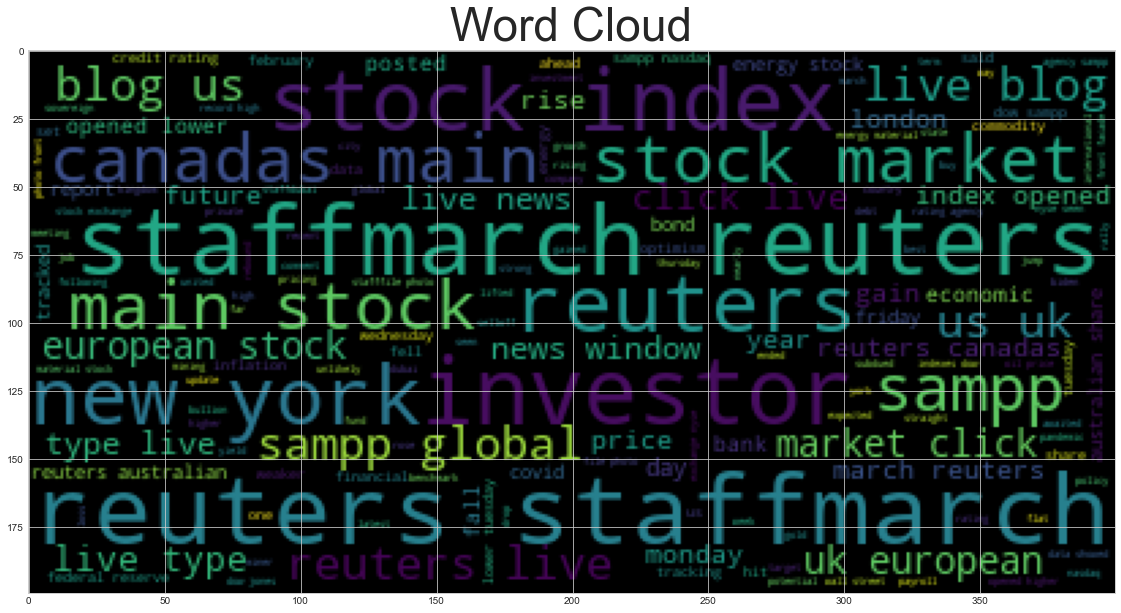

In [52]:
# Generate the stock word cloud
wc = WordCloud().generate(' '.join(stock_processed))
plt.imshow(wc)

# Add title to a Word Cloud 
plt.title("Word Cloud", fontdict={"fontsize":46})

# Named Entity Recognition

In this section, you will build a named entity recognition model for stock and visualize the tags using SpaCy.

In [53]:
import spacy
from spacy import displacy

In [54]:
# Load the spaCy model
nlp = spacy.load('en_core_web_sm')

## Stock NER

In [55]:
# Concatenate all of the stock text together
stock_joined = " ".join(stock_processed)

In [56]:
# Run the NER processor on all of the text
doc_stock = nlp(stock_joined)

# Add a title to the document
doc_stock.user_data["title"] = "Stock NER"

In [57]:
# Render the visualization
displacy.render(doc_stock, style='ent')

In [58]:
# List all Entities
print([ent.text for ent in doc_stock.ents])

['sampp dow', 'thursday', 'fred katayama', 'reuters', 'staffnew york march', 'reuters', 'sampp global', 'argentine state energy giant ypfs credit rating ccc', 'tuesday', 'fred katayama report', 'monday', 'cue federal reserve week', 'new york stock exchange', 'nyse', 'new york', 'february', 'reutersbrendan', 'us', 'tuesday', 'af', 'uk european', 'reuters live blog', 'uk european', 'amazon', 'uk european', 'nasdaq sampp post best week', 'five benchmark year', 'oneyear', 'ulta', 'uk european', 'dow', 'nasdaq', 'weekly', 'xinjiang', 'nasdaq reuters live blog', 'uk european', 'costco', 'uk european', 'slip virus concern gamestop corp rise', 'quarterly', 'sampp nio', 'year', 'nasdaq reuters live blog', 'uk european', 'xiaomi branding', 'uk', 'london', 'britain', 'november', 'chinese', 'xiaomi corp eligible', 'london', 'reuters', 'sampp global', 'brazil', 'south africa', 'london', 'reuters', 'sampp global', 'london', 'sampp global', 'saudi', 'last week', 'kingdoms de facto ruler crown', 'prin

---